In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, "dataset")

CLASS_NAMES = [
    "High_Motor_Coordination_Risk",
    "Mild_Motor_Coordination_Risk"
]

CLASS_DIRS = {
    class_name: os.path.join(DATASET_DIR, class_name)
    for class_name in CLASS_NAMES
}

print("Dataset path:", DATASET_DIR)
print("Classes found:", CLASS_DIRS)


Dataset path: c:\Projects\Dyspraxia\dataset
Classes found: {'High_Motor_Coordination_Risk': 'c:\\Projects\\Dyspraxia\\dataset\\High_Motor_Coordination_Risk', 'Mild_Motor_Coordination_Risk': 'c:\\Projects\\Dyspraxia\\dataset\\Mild_Motor_Coordination_Risk'}


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)


train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 200 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [30]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))

In [5]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # transfer learning


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


In [7]:
EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)


model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,218,917 (16.09 MB)

 Trainable params: 166,786 (651.51 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]


In [9]:
EPOCHS = 20

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 829ms/step - accuracy: 0.5450 - loss: 0.7870 - val_accuracy: 0.5510 - val_loss: 0.6838
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 522ms/step - accuracy: 0.6050 - loss: 0.7277 - val_accuracy: 0.5510 - val_loss: 0.6787
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step - accuracy: 0.6550 - loss: 0.6777 - val_accuracy: 0.5510 - val_loss: 0.6766
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 544ms/step - accuracy: 0.6100 - loss: 0.7148 - val_accuracy: 0.4694 - val_loss: 0.6837
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 573ms/step - accuracy: 0.6350 - loss: 0.7108 - val_accuracy: 0.6939 - val_loss: 0.6761
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 636ms/step - accuracy: 0.6450 - loss: 0.6635 - val_accuracy: 0.5510 - val_loss: 0.6741
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 780ms/step - accuracy: 0.5950 - loss: 0.7589 - val_accuracy: 0.5510 - val_loss: 0.6673
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 640ms/step - accuracy: 0.6550 - loss: 0.6575 - val_accuracy: 

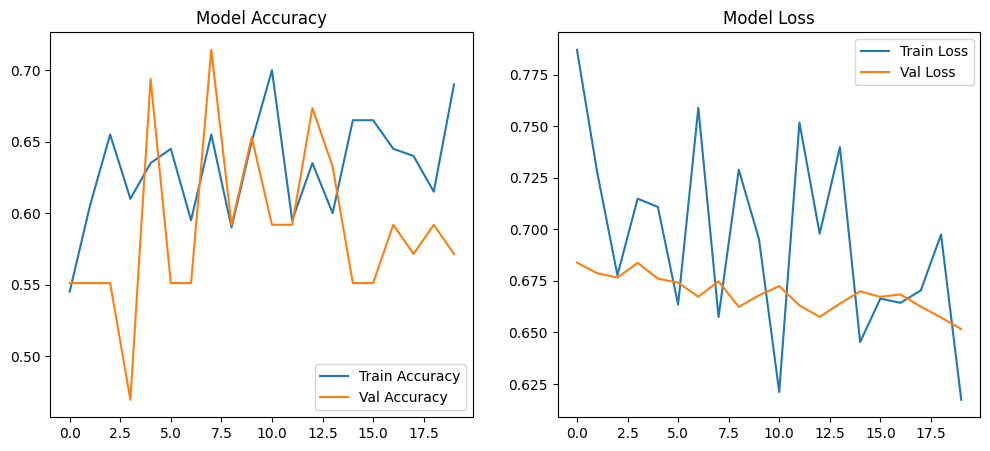

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [33]:
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

for layer in base_model.layers[-10:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True


In [38]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [39]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, lr_scheduler]


In [40]:
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,              
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 618ms/step - accuracy: 0.6500 - loss: 0.6612 - val_accuracy: 0.5714 - val_loss: 0.6684 - learning_rate: 1.0000e-05
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 446ms/step - accuracy: 0.7450 - loss: 0.5675 - val_accuracy: 0.5714 - val_loss: 0.6816 - learning_rate: 1.0000e-05
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 445ms/step - accuracy: 0.6500 - loss: 0.6375 - val_accuracy: 0.5918 - val_loss: 0.6648 - learning_rate: 1.0000e-05
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - accuracy: 0.6650 - loss: 0.6445 - val_accuracy: 0.5918 - val_loss: 0.6872 - learning_rate: 1.0000e-05
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6703 - loss: 0.7005
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 451ms/step - accuracy: 0.7300 - loss: 0.6035 - val_accuracy: 0.5510 - val_loss: 0.7223 - learning_rate: 1.0000e-05
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 0.6

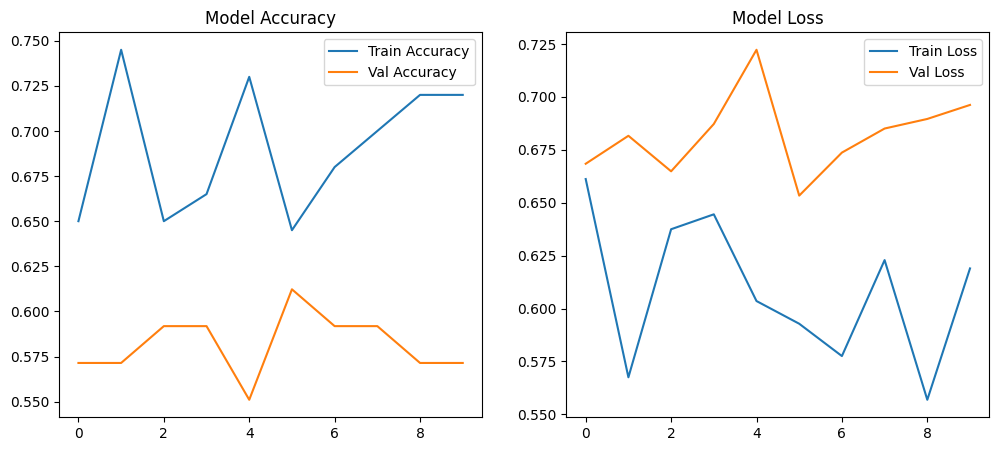

In [41]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.show()